# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0k/60.0k [00:10<00:00, 5.78kFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

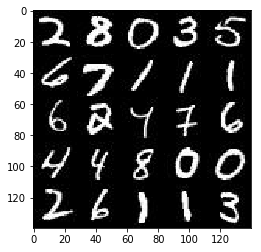

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

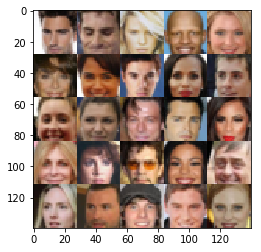

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.8.0


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, name='learn_rate')
    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        x1 = tf.layers.dense(z, 2*2*512)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_real)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.9346... Generator Loss: 12.3493
Epoch 1/2... Discriminator Loss: 0.9340... Generator Loss: 1.4193
Epoch 1/2... Discriminator Loss: 0.5166... Generator Loss: 3.1598
Epoch 1/2... Discriminator Loss: 0.0593... Generator Loss: 13.4844
Epoch 1/2... Discriminator Loss: 0.5743... Generator Loss: 2.9491
Epoch 1/2... Discriminator Loss: 1.6795... Generator Loss: 0.3602
Epoch 1/2... Discriminator Loss: 1.0078... Generator Loss: 3.5644
Epoch 1/2... Discriminator Loss: 0.3210... Generator Loss: 1.9500
Epoch 1/2... Discriminator Loss: 0.7996... Generator Loss: 1.3642
Epoch 1/2... Discriminator Loss: 0.1914... Generator Loss: 2.8116


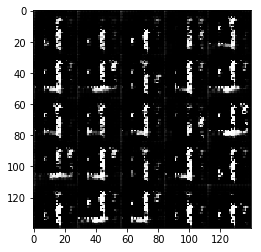

Epoch 1/2... Discriminator Loss: 0.3421... Generator Loss: 2.0395
Epoch 1/2... Discriminator Loss: 1.9254... Generator Loss: 0.6492
Epoch 1/2... Discriminator Loss: 0.4526... Generator Loss: 2.8681
Epoch 1/2... Discriminator Loss: 0.4797... Generator Loss: 1.9090
Epoch 1/2... Discriminator Loss: 0.2806... Generator Loss: 3.1966
Epoch 1/2... Discriminator Loss: 0.3621... Generator Loss: 4.9119
Epoch 1/2... Discriminator Loss: 0.8017... Generator Loss: 1.8581
Epoch 1/2... Discriminator Loss: 0.6831... Generator Loss: 2.3673
Epoch 1/2... Discriminator Loss: 1.6686... Generator Loss: 0.4372
Epoch 1/2... Discriminator Loss: 0.4512... Generator Loss: 2.9561


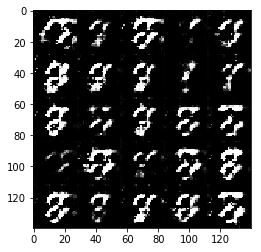

Epoch 1/2... Discriminator Loss: 0.5232... Generator Loss: 3.9780
Epoch 1/2... Discriminator Loss: 0.8348... Generator Loss: 1.1893
Epoch 1/2... Discriminator Loss: 0.9138... Generator Loss: 1.7106
Epoch 1/2... Discriminator Loss: 0.4595... Generator Loss: 4.8567
Epoch 1/2... Discriminator Loss: 0.3685... Generator Loss: 3.5477
Epoch 1/2... Discriminator Loss: 0.8312... Generator Loss: 3.1513
Epoch 1/2... Discriminator Loss: 0.4586... Generator Loss: 1.7873
Epoch 1/2... Discriminator Loss: 0.6403... Generator Loss: 2.5413
Epoch 1/2... Discriminator Loss: 2.1428... Generator Loss: 5.5569
Epoch 1/2... Discriminator Loss: 1.3801... Generator Loss: 3.4415


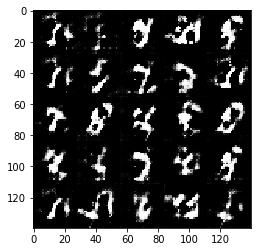

Epoch 1/2... Discriminator Loss: 1.2718... Generator Loss: 3.8181
Epoch 1/2... Discriminator Loss: 1.1127... Generator Loss: 0.7222
Epoch 1/2... Discriminator Loss: 0.6611... Generator Loss: 1.5211
Epoch 1/2... Discriminator Loss: 0.7865... Generator Loss: 1.3568
Epoch 1/2... Discriminator Loss: 1.0948... Generator Loss: 0.7007
Epoch 1/2... Discriminator Loss: 0.7994... Generator Loss: 3.3145
Epoch 1/2... Discriminator Loss: 0.5624... Generator Loss: 1.8506
Epoch 1/2... Discriminator Loss: 1.3429... Generator Loss: 3.3373
Epoch 1/2... Discriminator Loss: 0.8215... Generator Loss: 2.1582
Epoch 1/2... Discriminator Loss: 0.7810... Generator Loss: 1.3064


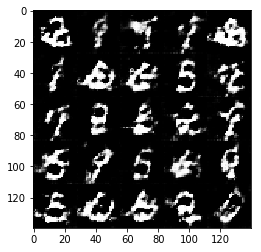

Epoch 1/2... Discriminator Loss: 0.7610... Generator Loss: 1.4343
Epoch 1/2... Discriminator Loss: 0.8864... Generator Loss: 1.1618
Epoch 1/2... Discriminator Loss: 0.9544... Generator Loss: 0.8721
Epoch 1/2... Discriminator Loss: 1.6124... Generator Loss: 2.5240
Epoch 1/2... Discriminator Loss: 1.0448... Generator Loss: 1.5402
Epoch 1/2... Discriminator Loss: 1.4004... Generator Loss: 0.4722
Epoch 2/2... Discriminator Loss: 0.7994... Generator Loss: 1.2499
Epoch 2/2... Discriminator Loss: 1.6331... Generator Loss: 4.2360
Epoch 2/2... Discriminator Loss: 0.9982... Generator Loss: 3.2951
Epoch 2/2... Discriminator Loss: 1.1490... Generator Loss: 3.4666


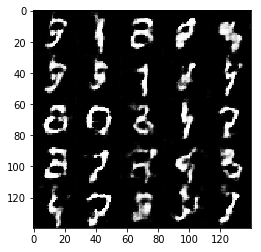

Epoch 2/2... Discriminator Loss: 0.5985... Generator Loss: 2.1795
Epoch 2/2... Discriminator Loss: 1.0026... Generator Loss: 1.8488
Epoch 2/2... Discriminator Loss: 0.8611... Generator Loss: 1.7613
Epoch 2/2... Discriminator Loss: 0.7674... Generator Loss: 1.1723
Epoch 2/2... Discriminator Loss: 2.0478... Generator Loss: 3.9606
Epoch 2/2... Discriminator Loss: 0.7633... Generator Loss: 1.2930
Epoch 2/2... Discriminator Loss: 0.9927... Generator Loss: 0.7417
Epoch 2/2... Discriminator Loss: 0.7273... Generator Loss: 1.7865
Epoch 2/2... Discriminator Loss: 0.7466... Generator Loss: 1.0539
Epoch 2/2... Discriminator Loss: 1.2261... Generator Loss: 0.5497


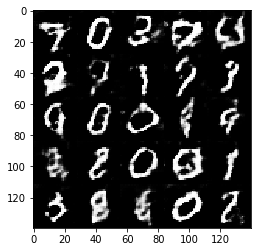

Epoch 2/2... Discriminator Loss: 0.9385... Generator Loss: 0.8493
Epoch 2/2... Discriminator Loss: 0.7762... Generator Loss: 1.1369
Epoch 2/2... Discriminator Loss: 0.9560... Generator Loss: 0.7299
Epoch 2/2... Discriminator Loss: 0.8638... Generator Loss: 2.4013
Epoch 2/2... Discriminator Loss: 0.7938... Generator Loss: 1.3169
Epoch 2/2... Discriminator Loss: 0.8600... Generator Loss: 1.2405
Epoch 2/2... Discriminator Loss: 1.0345... Generator Loss: 1.5373
Epoch 2/2... Discriminator Loss: 0.8013... Generator Loss: 1.9790
Epoch 2/2... Discriminator Loss: 1.1431... Generator Loss: 0.6749
Epoch 2/2... Discriminator Loss: 1.1749... Generator Loss: 0.6552


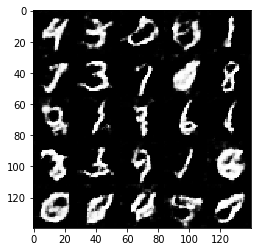

Epoch 2/2... Discriminator Loss: 1.0150... Generator Loss: 0.7530
Epoch 2/2... Discriminator Loss: 0.6778... Generator Loss: 1.1708
Epoch 2/2... Discriminator Loss: 2.5494... Generator Loss: 3.7780
Epoch 2/2... Discriminator Loss: 1.1235... Generator Loss: 2.1126
Epoch 2/2... Discriminator Loss: 0.7116... Generator Loss: 1.1392
Epoch 2/2... Discriminator Loss: 0.9683... Generator Loss: 0.8946
Epoch 2/2... Discriminator Loss: 0.7948... Generator Loss: 1.9011
Epoch 2/2... Discriminator Loss: 1.0281... Generator Loss: 0.8649
Epoch 2/2... Discriminator Loss: 0.7101... Generator Loss: 1.1786
Epoch 2/2... Discriminator Loss: 0.9237... Generator Loss: 1.2084


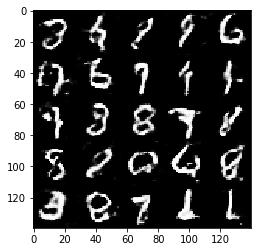

Epoch 2/2... Discriminator Loss: 1.8615... Generator Loss: 3.3250
Epoch 2/2... Discriminator Loss: 1.0690... Generator Loss: 0.7444
Epoch 2/2... Discriminator Loss: 0.7906... Generator Loss: 1.0706
Epoch 2/2... Discriminator Loss: 0.9828... Generator Loss: 1.1992
Epoch 2/2... Discriminator Loss: 1.1845... Generator Loss: 1.3166
Epoch 2/2... Discriminator Loss: 1.0514... Generator Loss: 1.2657
Epoch 2/2... Discriminator Loss: 1.2027... Generator Loss: 2.0999
Epoch 2/2... Discriminator Loss: 1.2132... Generator Loss: 0.4902
Epoch 2/2... Discriminator Loss: 0.8379... Generator Loss: 1.4283
Epoch 2/2... Discriminator Loss: 0.7196... Generator Loss: 1.0785


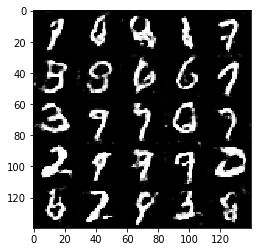

Epoch 2/2... Discriminator Loss: 0.6823... Generator Loss: 2.2376
Epoch 2/2... Discriminator Loss: 0.9873... Generator Loss: 1.0279
Epoch 2/2... Discriminator Loss: 1.0653... Generator Loss: 0.8501


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7034... Generator Loss: 1.1985
Epoch 1/1... Discriminator Loss: 0.3961... Generator Loss: 4.0471
Epoch 1/1... Discriminator Loss: 0.3356... Generator Loss: 2.1432
Epoch 1/1... Discriminator Loss: 0.7649... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 0.1729... Generator Loss: 2.9732
Epoch 1/1... Discriminator Loss: 0.6726... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 0.6717... Generator Loss: 9.9320
Epoch 1/1... Discriminator Loss: 0.2524... Generator Loss: 6.3218
Epoch 1/1... Discriminator Loss: 0.7066... Generator Loss: 2.7657
Epoch 1/1... Discriminator Loss: 0.2263... Generator Loss: 2.5138


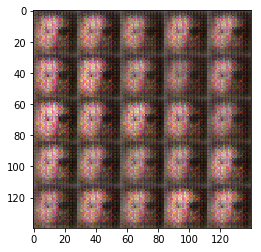

Epoch 1/1... Discriminator Loss: 0.2525... Generator Loss: 2.5170
Epoch 1/1... Discriminator Loss: 0.2511... Generator Loss: 2.2825
Epoch 1/1... Discriminator Loss: 0.2415... Generator Loss: 2.2055
Epoch 1/1... Discriminator Loss: 0.2337... Generator Loss: 2.1186
Epoch 1/1... Discriminator Loss: 0.4058... Generator Loss: 5.2530
Epoch 1/1... Discriminator Loss: 0.4538... Generator Loss: 1.7973
Epoch 1/1... Discriminator Loss: 0.2440... Generator Loss: 2.6686
Epoch 1/1... Discriminator Loss: 0.9601... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 0.4769... Generator Loss: 3.9474
Epoch 1/1... Discriminator Loss: 0.3282... Generator Loss: 3.2824


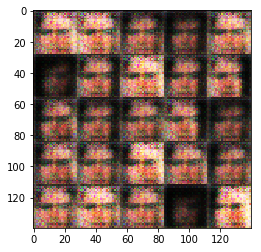

Epoch 1/1... Discriminator Loss: 0.8242... Generator Loss: 3.3872
Epoch 1/1... Discriminator Loss: 0.5631... Generator Loss: 2.5731
Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 2.7196
Epoch 1/1... Discriminator Loss: 0.5250... Generator Loss: 1.4600
Epoch 1/1... Discriminator Loss: 0.5782... Generator Loss: 2.5240
Epoch 1/1... Discriminator Loss: 0.7421... Generator Loss: 1.9140
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.4864
Epoch 1/1... Discriminator Loss: 0.8574... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 0.7427... Generator Loss: 1.1098
Epoch 1/1... Discriminator Loss: 0.6757... Generator Loss: 1.8994


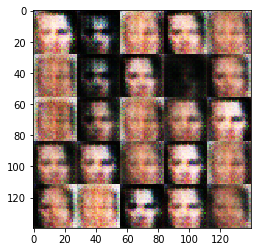

Epoch 1/1... Discriminator Loss: 0.6081... Generator Loss: 1.7373
Epoch 1/1... Discriminator Loss: 0.7536... Generator Loss: 0.9291
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.5553
Epoch 1/1... Discriminator Loss: 0.7756... Generator Loss: 1.4036
Epoch 1/1... Discriminator Loss: 0.6448... Generator Loss: 1.3442
Epoch 1/1... Discriminator Loss: 0.5836... Generator Loss: 1.6628
Epoch 1/1... Discriminator Loss: 0.7043... Generator Loss: 1.6391
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 1.1576
Epoch 1/1... Discriminator Loss: 0.6164... Generator Loss: 2.1905


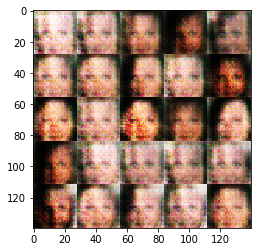

Epoch 1/1... Discriminator Loss: 0.6081... Generator Loss: 1.1854
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 1.0408
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 0.5115
Epoch 1/1... Discriminator Loss: 0.7685... Generator Loss: 0.9921
Epoch 1/1... Discriminator Loss: 1.0364... Generator Loss: 0.9742
Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.0006... Generator Loss: 1.1547
Epoch 1/1... Discriminator Loss: 0.5994... Generator Loss: 2.0488


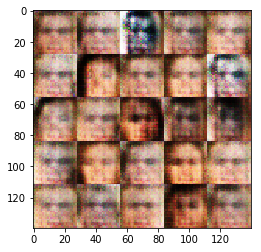

Epoch 1/1... Discriminator Loss: 0.8698... Generator Loss: 1.5161
Epoch 1/1... Discriminator Loss: 0.5589... Generator Loss: 1.6845
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 0.7492... Generator Loss: 1.3968
Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 1.1250
Epoch 1/1... Discriminator Loss: 0.8271... Generator Loss: 0.9896
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 1.0609
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 0.6780... Generator Loss: 1.4583
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 1.6688


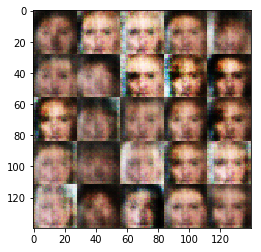

Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 0.6186... Generator Loss: 1.4899
Epoch 1/1... Discriminator Loss: 0.8513... Generator Loss: 1.3412
Epoch 1/1... Discriminator Loss: 0.9147... Generator Loss: 0.9149
Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 0.8084... Generator Loss: 1.7099
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 1.6818
Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 1.9759
Epoch 1/1... Discriminator Loss: 0.5548... Generator Loss: 1.4823
Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 1.5842


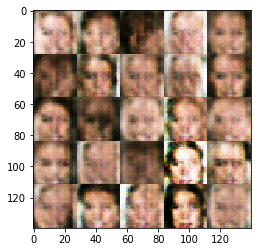

Epoch 1/1... Discriminator Loss: 0.7383... Generator Loss: 1.1816
Epoch 1/1... Discriminator Loss: 0.8298... Generator Loss: 1.9709
Epoch 1/1... Discriminator Loss: 0.8238... Generator Loss: 1.0710
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 1.5389
Epoch 1/1... Discriminator Loss: 0.7419... Generator Loss: 1.6493
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 1.0757
Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 1.3192
Epoch 1/1... Discriminator Loss: 0.7816... Generator Loss: 1.4922
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 0.7689


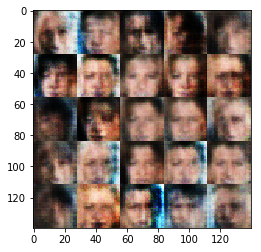

Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 1.1461
Epoch 1/1... Discriminator Loss: 0.8335... Generator Loss: 1.1806
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 0.9198... Generator Loss: 1.2329
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 0.9090... Generator Loss: 1.1125
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 2.2954
Epoch 1/1... Discriminator Loss: 0.7292... Generator Loss: 1.3658
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 0.9092... Generator Loss: 1.7855


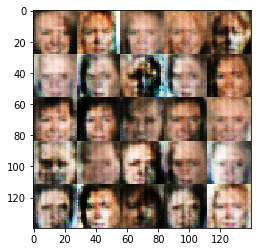

Epoch 1/1... Discriminator Loss: 0.9170... Generator Loss: 1.6201
Epoch 1/1... Discriminator Loss: 0.9545... Generator Loss: 1.1431
Epoch 1/1... Discriminator Loss: 0.9016... Generator Loss: 1.0185
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 1.2366
Epoch 1/1... Discriminator Loss: 0.8891... Generator Loss: 1.5745
Epoch 1/1... Discriminator Loss: 0.9918... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 1.2573
Epoch 1/1... Discriminator Loss: 0.9054... Generator Loss: 1.1548
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 1.6876


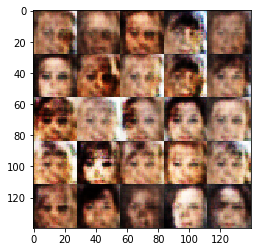

Epoch 1/1... Discriminator Loss: 1.0289... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 0.8152... Generator Loss: 1.5437
Epoch 1/1... Discriminator Loss: 0.8783... Generator Loss: 2.5028
Epoch 1/1... Discriminator Loss: 1.0262... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 0.8547... Generator Loss: 1.6094
Epoch 1/1... Discriminator Loss: 0.9168... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 1.0607... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 0.8792... Generator Loss: 1.7039


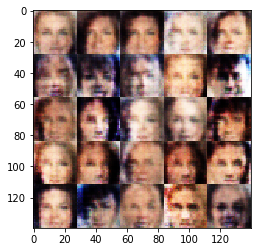

Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 0.8909... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 0.6886... Generator Loss: 1.4248
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 1.8720
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 1.3220
Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 1.5145
Epoch 1/1... Discriminator Loss: 0.9816... Generator Loss: 1.2227
Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 1.3836


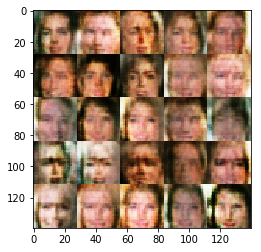

Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 0.9893
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 0.9185
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 1.6849
Epoch 1/1... Discriminator Loss: 0.9263... Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 0.7690... Generator Loss: 1.0854
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 0.6423
Epoch 1/1... Discriminator Loss: 0.9161... Generator Loss: 1.2289
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 0.9055... Generator Loss: 1.3204


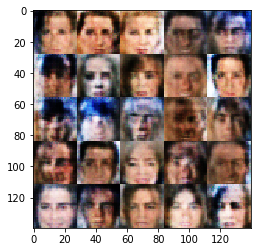

Epoch 1/1... Discriminator Loss: 0.7361... Generator Loss: 1.3032
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 2.0244
Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 0.8973... Generator Loss: 1.1807
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 0.9141... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 0.6875... Generator Loss: 1.5337
Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 1.9651


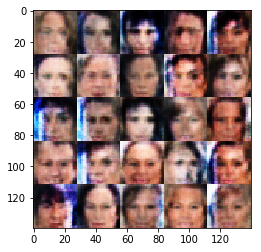

Epoch 1/1... Discriminator Loss: 0.9744... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 1.3852
Epoch 1/1... Discriminator Loss: 0.8843... Generator Loss: 1.3220
Epoch 1/1... Discriminator Loss: 0.9751... Generator Loss: 1.0516
Epoch 1/1... Discriminator Loss: 0.9461... Generator Loss: 1.2792
Epoch 1/1... Discriminator Loss: 0.8877... Generator Loss: 1.6204
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 1.6064
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 1.1366
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.6869


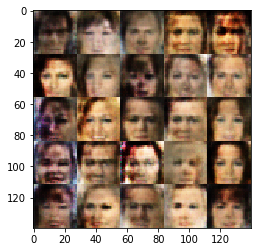

Epoch 1/1... Discriminator Loss: 0.9148... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 0.7013... Generator Loss: 1.4169
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 1.0983
Epoch 1/1... Discriminator Loss: 0.8738... Generator Loss: 1.4577
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 0.8877... Generator Loss: 1.0359
Epoch 1/1... Discriminator Loss: 0.9935... Generator Loss: 0.8492


In [16]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.